In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("fivethirtyeight")
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
    linewidth = 1
)
%config InlineBackend.figure_format = 'retina'

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
oil_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
holiday_events = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
stores = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
train_data = pd.read_csv(
    '/kaggle/input/store-sales-time-series-forecasting/train.csv',
    index_col='date',
    parse_dates=['date'],
)
test_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
transactions_data = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [3]:
print(f'Train data dimensions: {train_data.shape}')
print(f'Test data dimensions: {test_data.shape}')

Train data dimensions: (3000888, 5)
Test data dimensions: (28512, 5)


In [4]:
train_data.columns

Index(['id', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')

In [5]:
pivot_table = pd.pivot_table(train_data, values='sales', index='date', columns=['store_nbr'],aggfunc="sum")

In [6]:
test = train_data[(train_data['store_nbr'] == 1) & (train_data['family'] == 'AUTOMOTIVE')]

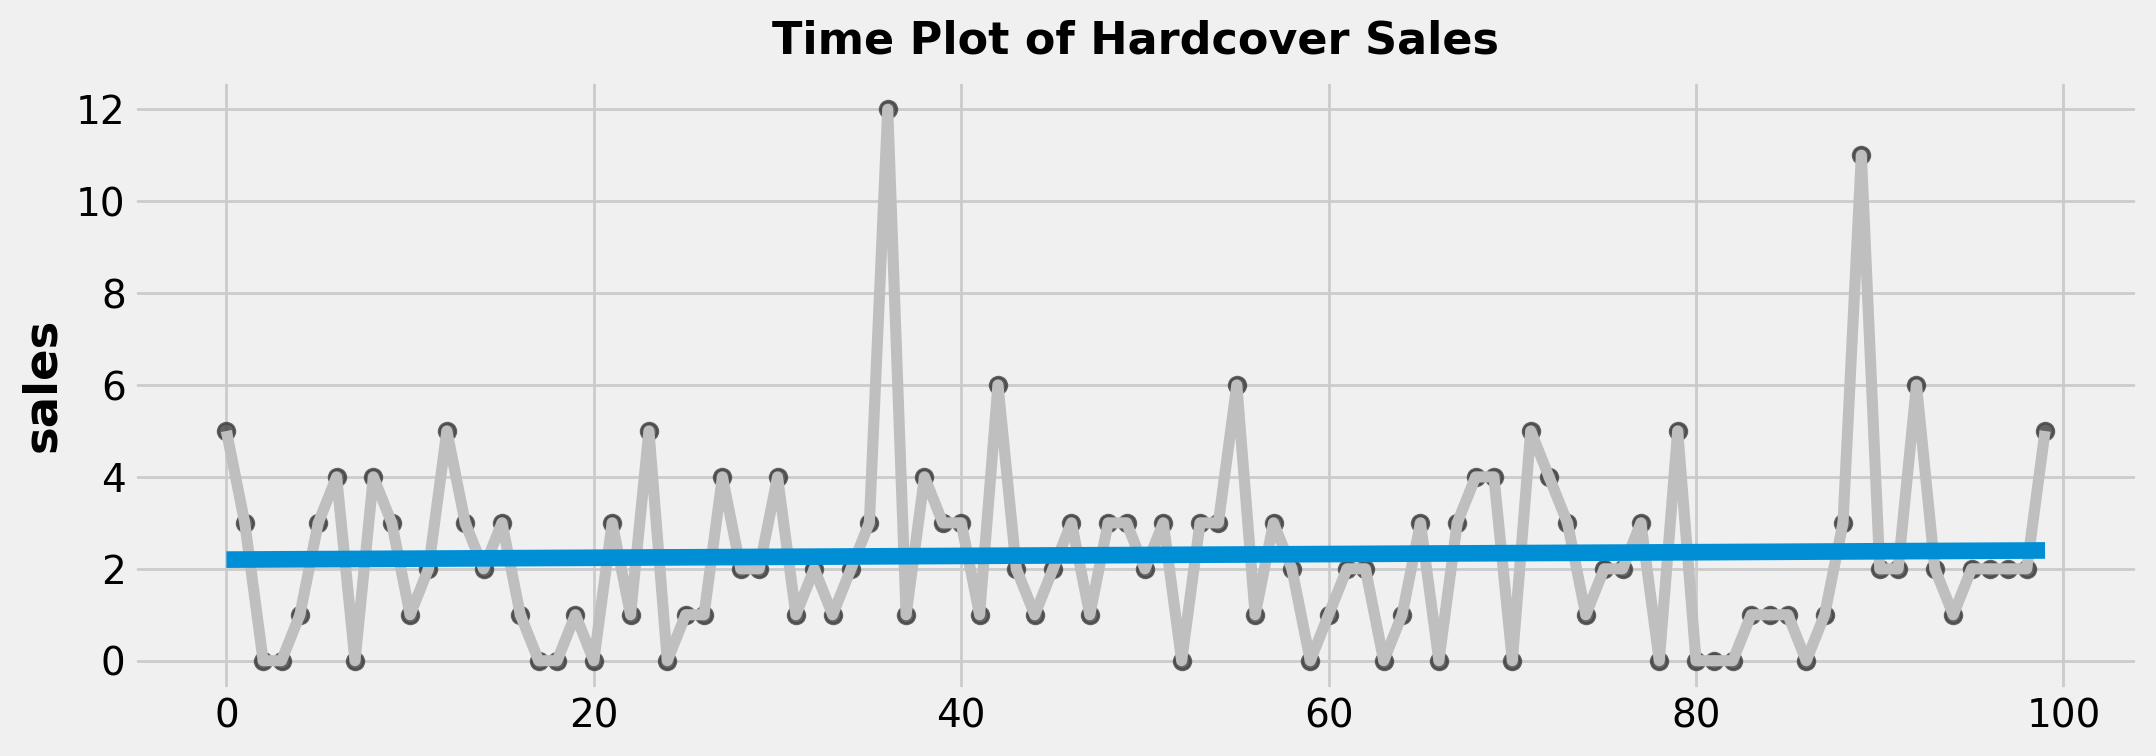

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(100), 'sales', data=test.iloc[100:200], color='0.75')
ax = sns.regplot(x= np.arange(100), y='sales', data=test.iloc[100:200], ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

In [8]:
df = test
df['sales'].shift(1)
df = df.reindex(columns=['sales', 'Lag_1'])

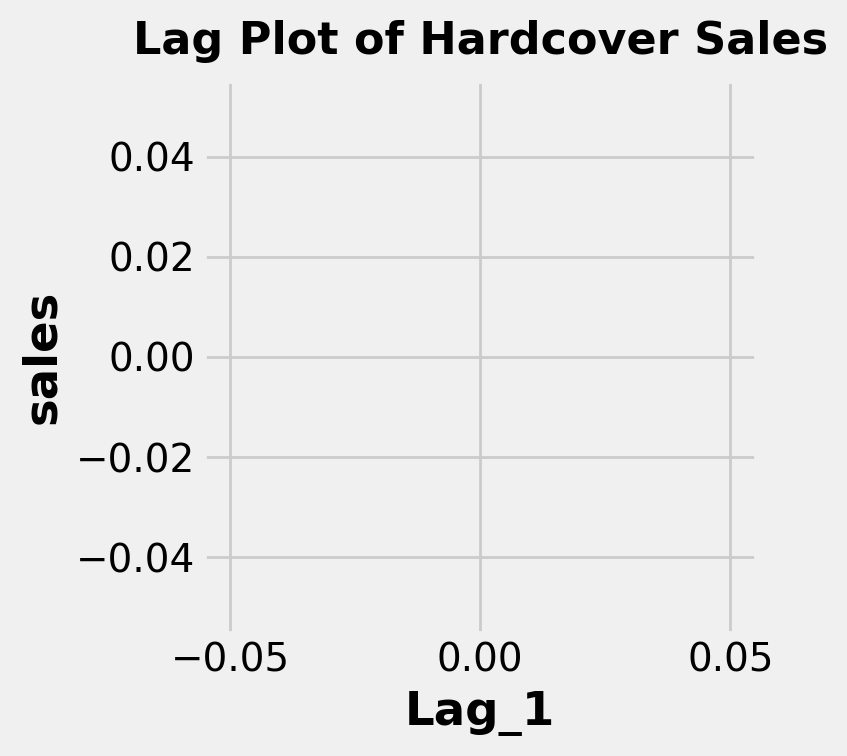

In [9]:
fig, ax = plt.subplots()
ax = sns.regplot(x='Lag_1', y='sales', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag Plot of Hardcover Sales');